# Importing libraries and downloading data

In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# change permission
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 99% 65.0M/66.0M [00:02<00:00, 19.7MB/s]
100% 66.0M/66.0M [00:02<00:00, 32.6MB/s]


In [4]:
!unzip "/content/creditcardfraud.zip" -d "/content/"

Archive:  /content/creditcardfraud.zip
  inflating: /content/creditcard.csv  


In [34]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
df = pd.read_csv("creditcard.csv", delimiter = ",")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [4]:
print("dataset contains {}% for non-fradulent class".format(df["Class"].value_counts()[0]*100/len(df["Class"])))


dataset contains 99.827251436938% for non-fradulent class


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
df.drop(["Time"], axis=1, inplace = True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<AxesSubplot:>

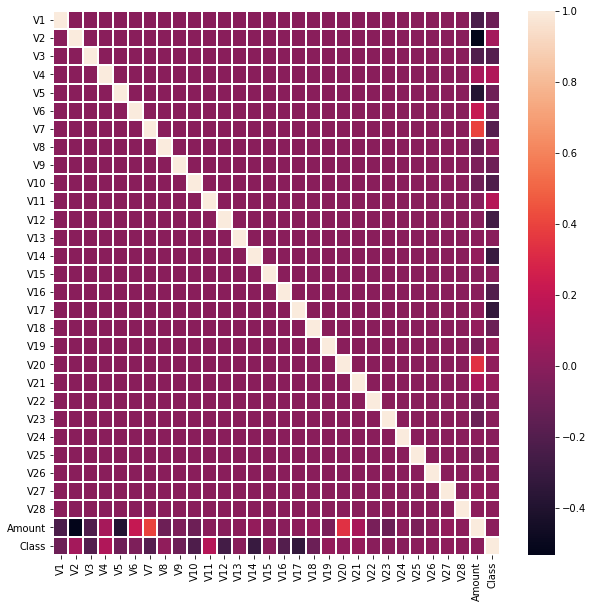

In [8]:
corr = df.corr("pearson")
plt.figure(figsize = (10,10))
sns.heatmap(corr, linewidth = 1)

<AxesSubplot:>

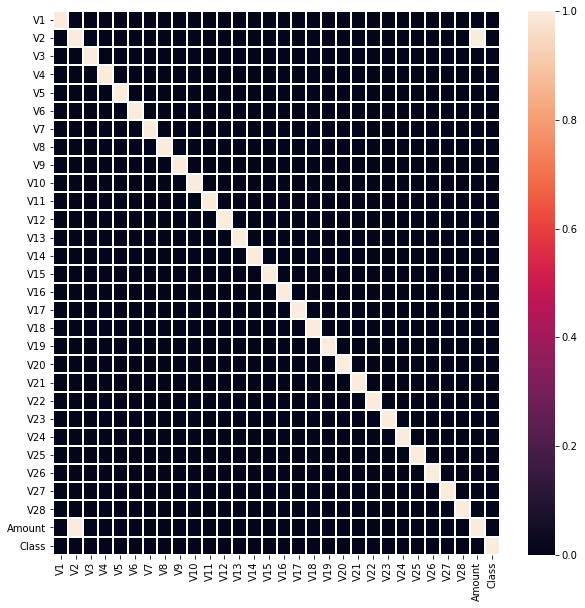

In [9]:
plt.figure(figsize = (10, 10))
sns.heatmap(abs(corr) > 0.5, linewidth = 1)

In [10]:
x, y = df.iloc[:, :-1], df.iloc[:, -1]
x.shape, y.shape

((284807, 29), (284807,))

In [11]:
x = np.array(x, dtype = "float")
y = np.array(y, dtype = "float")

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = .25)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((213605, 29), (71202, 29), (213605,), (71202,))

# Random Forest without SMOTE

In [13]:
rf_model = RandomForestClassifier(max_depth = None, n_jobs = -1)
params = {"n_estimators": [10, 50, 100, 250], 
          "max_features": [.1, .5, .9] 
          }

gridsearch = GridSearchCV(rf_model, params, cv = 3, n_jobs = -1, return_train_score = True, scoring = "f1", verbose = 10)
gridsearch.fit(x_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed: 57.9min remaining:  5.3min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 90.7min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'max_features': [0.1, 0.5, 0.9],
                         'n_estimators': [10, 50, 100, 250]},
             return_train_score=True, scoring='f1', verbose=10)

In [14]:
results = pd.DataFrame.from_dict(gridsearch.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,10.619389,0.146914,0.703834,0.026731,0.1,10,"{'max_features': 0.1, 'n_estimators': 10}",0.805687,0.840183,0.792627,0.812832,0.020061,12,0.975104,0.973085,0.970833,0.973007,0.001744
1,42.551434,1.342567,1.479718,0.269292,0.1,50,"{'max_features': 0.1, 'n_estimators': 50}",0.811060,0.836364,0.803653,0.817026,0.014004,11,1.000000,0.995918,0.997963,0.997961,0.001666
2,82.064870,3.223315,2.361010,0.063457,0.1,100,"{'max_features': 0.1, 'n_estimators': 100}",0.814815,0.866071,0.811060,0.830649,0.025095,8,1.000000,0.997963,1.000000,0.999321,0.000960
3,194.743201,5.845490,4.086600,0.319503,0.1,250,"{'max_features': 0.1, 'n_estimators': 250}",0.800000,0.840183,0.812785,0.817656,0.016762,10,1.000000,1.000000,1.000000,1.000000,0.000000
4,59.855161,5.754877,1.260298,0.011097,0.5,10,"{'max_features': 0.5, 'n_estimators': 10}",0.846847,0.833333,0.839286,0.839822,0.005530,3,0.975104,0.962185,0.979424,0.972237,0.007324


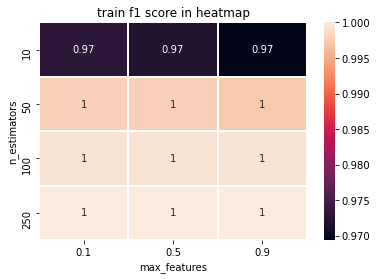

In [16]:
hmap = results.pivot("param_n_estimators", "param_max_features", "mean_train_score")
sns.heatmap(hmap, linewidth = 1, annot = True)
plt.xlabel("max_features")
plt.ylabel("n_estimators")
plt.title("train f1 score in heatmap")
plt.show()

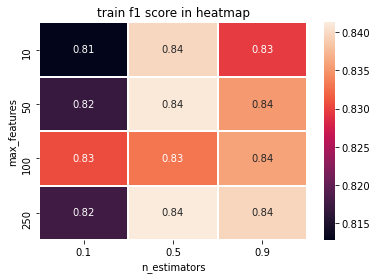

In [17]:
hmap = results.pivot("param_n_estimators", "param_max_features", "mean_test_score")
sns.heatmap(hmap, linewidth = 1, annot = True)
plt.ylabel("max_features")
plt.xlabel("n_estimators")
plt.title("train f1 score in heatmap")
plt.show()

In [35]:
n_estimators = 10
max_features = .5

In [44]:
model = RandomForestClassifier(max_depth = None, n_estimators = n_estimators, max_features = max_features, n_jobs = 3)
model.fit(x_train, y_train)

RandomForestClassifier(max_features=0.5, n_estimators=50, n_jobs=3)

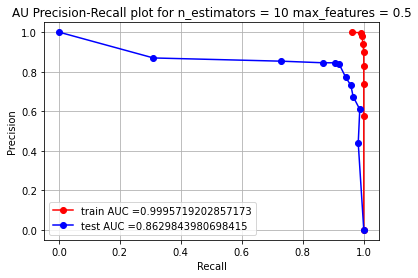

In [36]:
y_train_pred = model.predict_proba(x_train)
y_test_pred = model.predict_proba(x_test)

# code taken from reference ipynb
pre_train, rec_train, tr_thresholds = precision_recall_curve(y_train, y_train_pred[:, 1])
pre_test, rec_test, te_thresholds = precision_recall_curve(y_test, y_test_pred[:, 1])

plt.plot(pre_train, rec_train, "ro-", label="train AUC =" + str(auc(rec_train, pre_train)))
plt.plot(pre_test, rec_test, "bo-", label="test AUC ="+ str(auc(rec_test, pre_test)))
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("AU Precision-Recall plot for n_estimators = " + str(n_estimators) +  " max_features = " + str(max_features))
plt.grid()
plt.show()

In [45]:
print("train f1 score:", f1_score(y_train, model.predict(x_train))*100)
print("test f1 score:", f1_score(y_test, model.predict(x_test))*100)

train f1 score: 99.86431478968791
test f1 score: 88.98678414096916


# xgboost without SMOTE

In [15]:
rf_model = xgb.XGBClassifier()
params = {"n_estimators": [10, 50, 100, 250],  
          "max_depth": [4, 8], 
          "subsample": [.1, .5, .9], 
          "colsample_bytree": [.1, .5, .9]
          }

randomsearch = RandomizedSearchCV(rf_model, params, cv = 3, n_jobs = 3, return_train_score = True, scoring = "f1", verbose = 10)
randomsearch.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   55.7s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  4.4min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:  6.5min
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed: 10.3min finished
C:\Users\Nagesh\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:48:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                    

In [19]:
results = pd.DataFrame.from_dict(randomsearch.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_depth,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,49.487389,0.060685,0.826256,0.081439,0.5,250,4,0.1,"{'subsample': 0.5, 'n_estimators': 250, 'max_d...",0.796209,0.857143,0.820961,0.824771,0.025022,7,1.000000,1.000000,1.000000,1.000000,0.000000
1,4.685326,0.095229,0.272528,0.027462,0.1,10,8,0.5,"{'subsample': 0.1, 'n_estimators': 10, 'max_de...",0.741784,0.798165,0.789474,0.776474,0.024785,10,0.782022,0.791855,0.774487,0.782788,0.007111
2,127.953715,1.623424,0.337239,0.012684,0.9,250,4,0.5,"{'subsample': 0.9, 'n_estimators': 250, 'max_d...",0.796209,0.865801,0.847458,0.836489,0.029451,4,1.000000,1.000000,1.000000,1.000000,0.000000
3,73.037056,0.520644,0.326568,0.056114,0.5,100,8,0.9,"{'subsample': 0.5, 'n_estimators': 100, 'max_d...",0.811060,0.842105,0.849785,0.834317,0.016741,5,0.997963,1.000000,1.000000,0.999321,0.000960
4,88.298889,0.421401,0.331237,0.067855,0.5,250,4,0.5,"{'subsample': 0.5, 'n_estimators': 250, 'max_d...",0.809302,0.864629,0.842553,0.838828,0.022740,3,1.000000,1.000000,1.000000,1.000000,0.000000
5,29.787054,0.198501,0.232498,0.029123,0.1,100,8,0.9,"{'subsample': 0.1, 'n_estimators': 100, 'max_d...",0.762332,0.830357,0.826087,0.806259,0.031110,8,0.878465,0.850325,0.854626,0.861139,0.012377
6,6.982240,0.628832,0.165118,0.046988,0.1,50,4,0.1,"{'subsample': 0.1, 'n_estimators': 50, 'max_de...",0.752381,0.783019,0.824561,0.786654,0.029579,9,0.828508,0.800926,0.836689,0.822041,0.015300
7,170.697486,3.636111,0.372265,0.026185,0.9,250,4,0.9,"{'subsample': 0.9, 'n_estimators': 250, 'max_d...",0.824074,0.852174,0.862069,0.846106,0.016094,1,1.000000,1.000000,1.000000,1.000000,0.000000
8,44.458384,0.280888,0.180796,0.021700,0.9,50,4,0.9,"{'subsample': 0.9, 'n_estimators': 50, 'max_de...",0.816514,0.854626,0.846154,0.839098,0.016339,2,0.975000,0.966387,0.968553,0.969980,0.003658
9,6.393540,0.995519,0.145437,0.009037,0.9,10,4,0.5,"{'subsample': 0.9, 'n_estimators': 10, 'max_de...",0.805556,0.834081,0.843882,0.827839,0.016257,6,0.893246,0.876957,0.884956,0.885053,0.006650


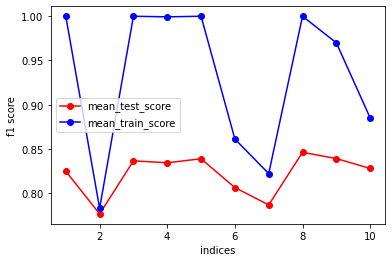

In [21]:
plt.figure()
plt.plot(range(1, len(results["mean_test_score"])+1), results["mean_test_score"], "ro-", label = "mean_test_score")
plt.plot(range(1, len(results["mean_train_score"])+1), results["mean_train_score"], "bo-", label = "mean_train_score")
plt.legend()
plt.xlabel("indices")
plt.ylabel("f1 score")
plt.grid()
plt.show()

In [40]:
n_estimators = 50
max_depth = 4
subsample = .9
colsample_bytree = .9

In [41]:
model = xgb.XGBClassifier(max_depth = max_depth, n_estimators = n_estimators, subsample = subsample, n_jobs = 3, colsample_bytree = colsample_bytree)
model.fit(x_train, y_train)

C:\Users\Nagesh\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:45:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=3, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

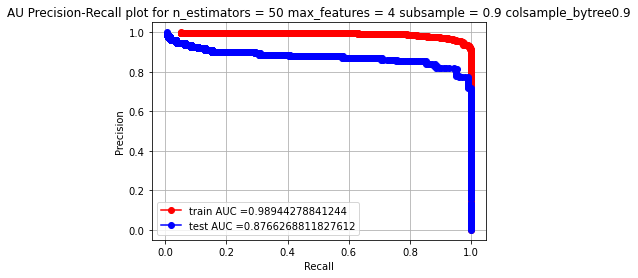

In [36]:
y_train_pred = model.predict_proba(x_train)
y_test_pred = model.predict_proba(x_test)

# code taken from reference ipynb
pre_train, rec_train, tr_thresholds = precision_recall_curve(y_train, y_train_pred[:, 1])
pre_test, rec_test, te_thresholds = precision_recall_curve(y_test, y_test_pred[:, 1])

plt.plot(pre_train, rec_train, "ro-", label="train AUC =" + str(auc(rec_train, pre_train)))
plt.plot(pre_test, rec_test, "bo-", label="test AUC ="+ str(auc(rec_test, pre_test)))
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("AU Precision-Recall plot for n_estimators = " + str(n_estimators) +  " max_features = " + str(max_depth) + " subsample = " + str(subsample) + " colsample_bytree" + str(colsample_bytree))
plt.grid()
plt.show()

In [43]:
print("train f1 score:", f1_score(y_train, model.predict(x_train))*100)
print("test f1 score:", f1_score(y_test, model.predict(x_test))*100)

train f1 score: 95.0354609929078
test f1 score: 86.87782805429865


In [14]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x_train, y_train)
x_smote.shape

(426472, 29)

# Random Forest with SMOTE

In [15]:
rf_model = RandomForestClassifier(max_depth = None, n_jobs = -1)
params = {"n_estimators": [10, 50, 100, 250], 
          "max_features": [.1, .5, .9] 
          }

gridsearch = GridSearchCV(rf_model, params, cv = 3, n_jobs = 3, return_train_score = True, scoring = "f1", verbose = 10)
gridsearch.fit(x_smote, y_smote)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   19.9s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  4.1min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  9.7min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 31.0min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 67.8min
[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed: 171.5min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=3,
             param_grid={'max_features': [0.1, 0.5, 0.9],
                         'n_estimators': [10, 50, 100, 250]},
             return_train_score=True, scoring='f1', verbose=10)

In [16]:
results = pd.DataFrame.from_dict(gridsearch.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,15.863720,0.371933,0.458993,0.066421,0.1,10,"{'max_features': 0.1, 'n_estimators': 10}",0.999838,0.999803,0.999866,0.999836,0.000026,4,0.999996,1.000000,0.999986,0.999994,0.000006
1,69.340531,0.520075,1.933708,0.404237,0.1,50,"{'max_features': 0.1, 'n_estimators': 50}",0.999824,0.999866,0.999894,0.999862,0.000029,3,1.000000,0.999996,1.000000,0.999999,0.000002
2,140.633561,0.454776,2.791984,0.321487,0.1,100,"{'max_features': 0.1, 'n_estimators': 100}",0.999810,0.999880,0.999894,0.999862,0.000037,2,1.000000,1.000000,1.000000,1.000000,0.000000
3,312.073681,2.219156,7.810548,0.410720,0.1,250,"{'max_features': 0.1, 'n_estimators': 250}",0.999817,0.999873,0.999902,0.999864,0.000035,1,1.000000,1.000000,1.000000,1.000000,0.000000
4,86.025691,1.115723,0.522372,0.169793,0.5,10,"{'max_features': 0.5, 'n_estimators': 10}",0.999768,0.999789,0.999775,0.999777,0.000009,8,0.999989,0.999996,0.999986,0.999991,0.000004


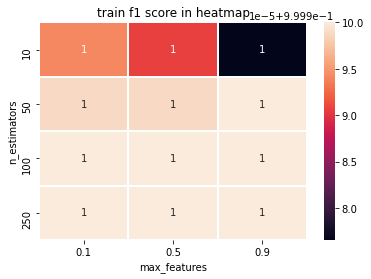

In [27]:
hmap = results.pivot("param_n_estimators", "param_max_features", "mean_train_score")
sns.heatmap(hmap, linewidth = 1, annot = True)
plt.xlabel("max_features")
plt.ylabel("n_estimators")
plt.title("train f1 score in heatmap")
plt.show()

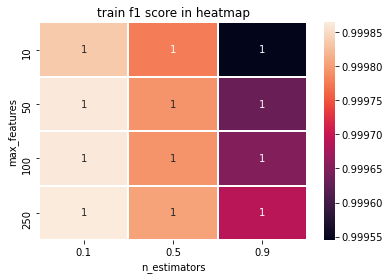

In [18]:
hmap = results.pivot("param_n_estimators", "param_max_features", "mean_test_score")
sns.heatmap(hmap, linewidth = 1, annot = True)
plt.ylabel("max_features")
plt.xlabel("n_estimators")
plt.title("train f1 score in heatmap")
plt.show()

In [46]:
n_estimators = 10
max_features = .1

In [47]:
model = RandomForestClassifier(max_depth = None, n_estimators = n_estimators, max_features = max_features, n_jobs = 3)
model.fit(x_smote, y_smote)

RandomForestClassifier(max_features=0.1, n_estimators=10, n_jobs=3)

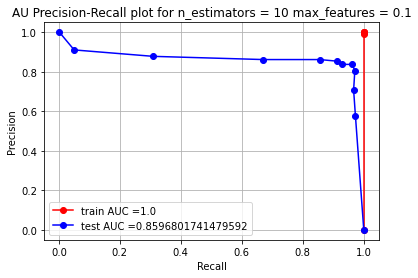

In [25]:
y_train_pred = model.predict_proba(x_smote)
y_test_pred = model.predict_proba(x_test)

# code taken from reference ipynb
pre_train, rec_train, tr_thresholds = precision_recall_curve(y_smote, y_train_pred[:, 1])
pre_test, rec_test, te_thresholds = precision_recall_curve(y_test, y_test_pred[:, 1])

plt.plot(pre_train, rec_train, "ro-", label="train AUC =" + str(auc(rec_train, pre_train)))
plt.plot(pre_test, rec_test, "bo-", label="test AUC ="+ str(auc(rec_test, pre_test)))
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("AU Precision-Recall plot for n_estimators = " + str(n_estimators) +  " max_features = " + str(max_features))
plt.grid()
plt.show()

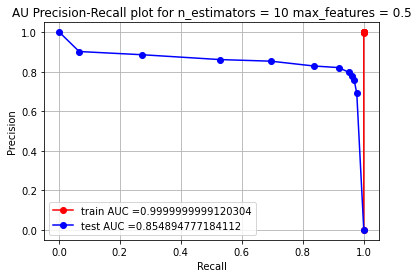

In [22]:
y_train_pred = model.predict_proba(x_smote)
y_test_pred = model.predict_proba(x_test)

# code taken from reference ipynb
pre_train, rec_train, tr_thresholds = precision_recall_curve(y_smote, y_train_pred[:, 1])
pre_test, rec_test, te_thresholds = precision_recall_curve(y_test, y_test_pred[:, 1])

plt.plot(pre_train, rec_train, "ro-", label="train AUC =" + str(auc(rec_train, pre_train)))
plt.plot(pre_test, rec_test, "bo-", label="test AUC ="+ str(auc(rec_test, pre_test)))
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("AU Precision-Recall plot for n_estimators = " + str(n_estimators) +  " max_features = " + str(max_features))
plt.grid()
plt.show()

In [48]:
print("train f1 score:", f1_score(y_train, model.predict(x_train))*100)
print("smote f1 score:", f1_score(y_smote, model.predict(x_smote))*100)
print("test f1 score:", f1_score(y_test, model.predict(x_test))*100)

train f1 score: 99.86468200270636
smote f1 score: 99.99976551856741
test f1 score: 88.41201716738198


# xgboost with SMOTE

In [28]:
rf_model = xgb.XGBClassifier()
params = {"n_estimators": [10, 50, 100, 250],  
          "max_depth": [4, 8], 
          "subsample": [.1, .5, .9], 
          "colsample_bytree": [.1, .5, .9]
          }

randomsearch = RandomizedSearchCV(rf_model, params, cv = 3, n_jobs = 3, return_train_score = True, scoring = "f1", verbose = 10)
randomsearch.fit(x_smote, y_smote)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  2.4min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  4.1min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  6.8min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:  8.2min
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed: 10.0min finished
C:\Users\Nagesh\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:20:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                    

In [29]:
results = pd.DataFrame.from_dict(randomsearch.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_depth,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,142.210267,0.963473,0.516959,0.066438,0.5,100,4,0.9,"{'subsample': 0.5, 'n_estimators': 100, 'max_d...",0.999452,0.999395,0.999550,0.999466,0.000064,3,0.999701,0.999740,0.999729,0.999723,0.000016
1,14.969329,0.261003,0.331569,0.049081,0.5,50,4,0.1,"{'subsample': 0.5, 'n_estimators': 50, 'max_de...",0.980141,0.982994,0.983569,0.982235,0.001499,8,0.980710,0.984104,0.984367,0.983060,0.001665
2,85.866617,0.539388,0.464664,0.004646,0.5,100,4,0.5,"{'subsample': 0.5, 'n_estimators': 100, 'max_d...",0.999276,0.999283,0.999473,0.999344,0.000091,4,0.999666,0.999638,0.999655,0.999653,0.000012
3,148.123392,3.100797,0.949009,0.140686,0.1,250,8,0.5,"{'subsample': 0.1, 'n_estimators': 250, 'max_d...",0.999662,0.999740,0.999712,0.999705,0.000032,2,0.999947,0.999944,0.999951,0.999947,0.000003
4,68.320388,0.309674,0.439982,0.010379,0.1,100,4,0.9,"{'subsample': 0.1, 'n_estimators': 100, 'max_d...",0.999171,0.999262,0.999339,0.999257,0.000069,5,0.999476,0.999497,0.999487,0.999487,0.000009
5,18.789860,0.463739,0.292208,0.024280,0.5,10,8,0.5,"{'subsample': 0.5, 'n_estimators': 10, 'max_de...",0.992531,0.995729,0.995418,0.994559,0.001440,6,0.993211,0.996318,0.996078,0.995202,0.001411
6,4.488670,0.155025,0.283208,0.017736,0.1,10,4,0.1,"{'subsample': 0.1, 'n_estimators': 10, 'max_de...",0.937933,0.939314,0.940624,0.939291,0.001099,10,0.937313,0.939873,0.941756,0.939648,0.001821
7,11.081141,0.610004,0.293542,0.017224,0.1,10,8,0.5,"{'subsample': 0.1, 'n_estimators': 10, 'max_de...",0.991282,0.993647,0.993647,0.992859,0.001115,7,0.991787,0.994510,0.994053,0.993450,0.001190
8,79.923076,0.354695,0.465331,0.046709,0.5,50,8,0.5,"{'subsample': 0.5, 'n_estimators': 50, 'max_de...",0.999691,0.999733,0.999754,0.999726,0.000026,1,0.999947,0.999937,0.999940,0.999941,0.000004
9,5.617765,1.121993,0.261188,0.013963,0.1,10,4,0.5,"{'subsample': 0.1, 'n_estimators': 10, 'max_de...",0.967947,0.965776,0.966521,0.966748,0.000901,9,0.967274,0.967010,0.967046,0.967110,0.000117


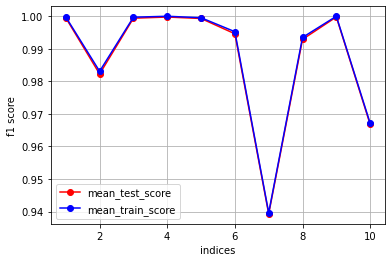

In [30]:
plt.figure()
plt.plot(range(1, len(results["mean_test_score"])+1), results["mean_test_score"], "ro-", label = "mean_test_score")
plt.plot(range(1, len(results["mean_train_score"])+1), results["mean_train_score"], "bo-", label = "mean_train_score")
plt.legend()
plt.xlabel("indices")
plt.ylabel("f1 score")
plt.grid()
plt.show()

In [49]:
n_estimators = 100
max_depth = 4
subsample = .5
colsample_bytree = .5

In [50]:
model = xgb.XGBClassifier(max_depth = max_depth, n_estimators = n_estimators, subsample = subsample, n_jobs = 3, colsample_bytree = colsample_bytree)
model.fit(x_smote, y_smote)

C:\Users\Nagesh\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=3, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

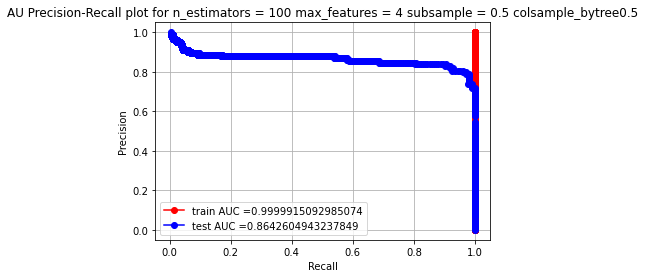

In [33]:
y_train_pred = model.predict_proba(x_smote)
y_test_pred = model.predict_proba(x_test)

# code taken from reference ipynb
pre_train, rec_train, tr_thresholds = precision_recall_curve(y_smote, y_train_pred[:, 1])
pre_test, rec_test, te_thresholds = precision_recall_curve(y_test, y_test_pred[:, 1])

plt.plot(pre_train, rec_train, "ro-", label="train AUC =" + str(auc(rec_train, pre_train)))
plt.plot(pre_test, rec_test, "bo-", label="test AUC ="+ str(auc(rec_test, pre_test)))
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("AU Precision-Recall plot for n_estimators = " + str(n_estimators) +  " max_features = " + str(max_depth) + " subsample = " + str(subsample) + " colsample_bytree" + str(colsample_bytree))
plt.grid()
plt.show()

In [51]:
print("train f1 score:", f1_score(y_train, model.predict(x_train))*100)
print("smote f1 score:", f1_score(y_smote, model.predict(x_smote))*100)
print("test f1 score:", f1_score(y_test, model.predict(x_test))*100)

train f1 score: 83.44671201814057
smote f1 score: 99.96483924502827
test f1 score: 68.370607028754
